In [1]:
import warnings
import numpy as np
import numba
import matplotlib.pyplot as plt
import hist
s = hist.tag.Slicer()

from coffea import util

from topcoffea.modules import WCFit

import os

In [2]:
wcstring = {}
wcstring['cHWtil'] = r'$\tilde{c}_{HW}$'
wcstring['cHW'] = r'$c_{HW}$'
wcstring['cHBtil'] = r'$\tilde{c}_{HB}$'
wcstring['cHB'] = r'$c_{HB}$'
wcstring['cHWBtil'] = r'$\tilde{c}_{HWB}$'
wcstring['cHWB'] = r'$c_{HWB}$'
wcstring['cHj1'] = r'$c_{Hj1}$'
wcstring['cHj3'] = r'$c_{Hj3}$'
wcstring['cHbox'] = r'$c_{Hbox}$'
wcstring['cHDD'] = r'$c_{HDD}$'
wcstring['cHd'] = r'$c_{Hd}$'
wcstring['cHu'] = r'$c_{Hu}$'
wcstring['cHudRe'] = r'Re($c_{Hud}$)'
wcstring['cHudIm'] = r'Im($c_{Hud}$)'
wcstring['cdBRe'] = r'Re($c_{dB}$)'
wcstring['cdBIm'] = r'Im($c_{dB}$)'
wcstring['cuBRe'] = r'Re($c_{uB}$)'
wcstring['cuBIm'] = r'Im($c_{uB}$)'
wcstring['cuWRe'] = r'Re($c_{uW}$)'
wcstring['cuWIm'] = r'Im($c_{uW}$)'
wcstring['cdWRe'] = r'Re($c_{dW}$)'
wcstring['cdWIm'] = r'Im($c_{dW}$)'
wcstring['cutbd1Im'] = r'???'

for x in wcstring.keys():
    print(x)

cHWtil
cHW
cHBtil
cHB
cHWBtil
cHWB
cHj1
cHj3
cHbox
cHDD
cHd
cHu
cHudRe
cHudIm
cdBRe
cdBIm
cuBRe
cuBIm
cuWRe
cuWIm
cdWRe
cdWIm
cutbd1Im


In [3]:
smpoint = {}
allones = {}

for x in wcstring.keys():    
    smpoint[x] = 0
    allones[x] = 1
    
smpoint['cSM'] = 1
allones['cSM'] = 1

In [38]:
# New reweight function
def reweight(myhist, wc, wcval, rwpoint = smpoint):

    wcbins = [myhist.axes[myhist.axes.name.index('wc')].bin(i) for i in range(0,myhist.axes[myhist.axes.name.index('wc')].size)]
    
    # vector of WC for each rw point
    points = {}
    for p in wcbins:

        # Start with each point is SM
        points[p] = smpoint.copy()

        if "SM" in p:
            # nothing to add
            continue

        for x in p.split(","):
            v = x.split("=")
            points[p][v[0]] = float(v[1])

    from functools import reduce
    parameters = list(rwpoint.keys()) #sorted(reduce(set.union, (set(keys) for keys in points), set()))
    #print(parameters)
    
    npar = len(parameters)-1
    ntri = npar*(npar+1)//2
    #if len(points) < ntri:
    #    print(f"Have {len(points)} reweight points for {npar} paramteters. Need at least {ntri}")

    def compute_scaling(weights, npar):
        """Compute scaling matrix
            weights: nevents by npar*(npar+1)/2-1 array (SM point assumed 1.0)
        """
        mats = np.zeros((len(weights), npar, npar))
        mats[:, 0, 0] = 1.0
        for ievt, row in enumerate(weights):
            idx = 2*npar - 1
            for i in range(1, npar):
                halfci = row[2*i-2]
                ci = row[2*i-1]
                ai = -3 + 4*halfci - ci
                bii = 2 - 4*halfci + 2*ci
                mats[ievt, 0, i] = ai/2
                mats[ievt, i, 0] = ai/2
                mats[ievt, i, i] = bii
                for j in range(i+1, npar):
                    cj = row[2*j-1]
                    cij = row[idx]
                    bij = 1 - ci - cj + cij
                    mats[ievt, i, j] += bij / 2
                    mats[ievt, j, i] += bij / 2
                    idx += 1

        assert idx == len(row)
        return mats

    def compute_scaling_nonsm(weights, npar):
        """Compute scaling matrix
            weights: nevents by npar*(npar+1)/2
        """
        mats = np.zeros((len(weights), npar, npar))
        for ievt, row in enumerate(weights):
            idx = 2*npar - 1
            csm = row[0]
            mats[ievt, 0, 0] = csm
            for i in range(1, npar):
                halfci = row[2*i-1]
                ci = row[2*i]
                ai = -3*csm + 4*halfci - ci
                bii = 2*csm - 4*halfci + 2*ci
                mats[ievt, 0, i] = ai/2
                mats[ievt, i, 0] = ai/2
                mats[ievt, i, i] = bii
                for j in range(i+1, npar):
                    cj = row[2*j]
                    cij = row[idx]
                    bij = 1 - ci - cj + cij
                    mats[ievt, i, j] += bij / 2
                    mats[ievt, j, i] += bij / 2
                    idx += 1

            assert idx == len(row)
        return mats

    data = myhist.values()
    for i in range(1,data.shape[1]):
        data[:,i] = myhist.values()[:,i-1]/myhist.values()[:,-1]
    data[:,0] = 1 #myhist.values()[:,-1]

    scaling = compute_scaling(data,npar)
    #print(scaling)

    coefvec = np.zeros(npar)
    coefvec[0] = 1 # SM
    coefvec[parameters.index(wc)+1] = wcval
    
    def weightfor(coef):
        return np.einsum("i,eij,j->e", coef, scaling, coef)
    
    #print(coefvec)
    print(weightfor(coefvec))
    
    return weightfor(coefvec)

In [39]:
samp1 = "VBF_SMEFTsim_topU3l_NP1"
output1 = util.load("coffea/"+samp1+".coffea")

samp2 = "VBF_SMEFTsim_topU3l_NP1_start1"
output2 = util.load("coffea/"+samp2+".coffea")

In [40]:
h1 = output1['hpt']
h2 = output2['hpt']

In [41]:
h1.values().shape

(200, 276)

In [42]:
def plot_with_ratio(wc, wcval, name, h1in, h2in, din, y0=[], y1=[], y2=[], rebin=1):
    fig, ax = plt.subplots(3,1,sharex=True, gridspec_kw={'height_ratios': [3, 1, 1]}, figsize=(10,12))
    fig.subplots_adjust(hspace=0.1)
    
    var = h1in.axes[0].name
    hist1 = h1in[{var:s[::hist.rebin(rebin)]}]
    hist2 = h2in[{var:s[::hist.rebin(rebin)]}]
    hist3 = din[{var:s[::hist.rebin(rebin)]}]
    
    bin_width = hist1.axes[0].widths[0]
    
    sm = hist1[{'wc':'SM'}].values()/(10**6)/bin_width
    sm_err = np.sqrt(hist1[{'wc':'SM'}].variances())/(10**6)/bin_width

    hist1_norm = reweight(hist1, wc, wcval)/(10**6)/bin_width
    hist1_norm_err = np.sqrt(hist1[{'wc':'SM'}].variances())/(10**6)/bin_width

    #rwpoint = smpoint
    #'cHB=1,cHBtil=1,cHDD=1,cHW=1,cHWB=1,cHWBtil=1,cHWtil=1,cHbox=1,cHd=1,cHj1=1,cHj3=1,cHu=1,cHudIm=1,cHudRe=1,cdBIm=1,cdBRe=1,cdWRe=1,cuBIm=1,cuBRe=1,cuWIm=1,cuWRe=1,cutbd1Im=1'

    hist2_norm = reweight(hist2, wc, wcval, allones)/(10**6)/bin_width
    hist2_norm_err = np.sqrt(hist2[{'wc':'SM'}].variances())/(10**6)/bin_width

    d_norm = hist3[{'wc':'SM'}].values()/(10**6)/bin_width
    d_norm_err = np.sqrt(hist3[{'wc':'SM'}].variances())/(10**6)/bin_width
    
    the_bins = hist1[{'wc':'SM'}].axes[0].edges
    bin_centers = the_bins[:-1] + 0.5*np.diff(the_bins)
    
    ax[0].hist(the_bins[:-1],
               bins=the_bins,
               weights=sm,
               label='SM',
               histtype='step',
               color='black',
               lw=2,
               linestyle='dotted',
               )  
    ax[0].errorbar(bin_centers, sm, yerr=sm_err, linestyle='',color='black',lw=2)
    
    ax[0].hist(the_bins[:-1],
               bins=the_bins,
               weights=hist1_norm,
               label='RW from 0',
               histtype='step',
               color='tab:red',
               lw=2
               )        
    ax[0].errorbar(bin_centers, hist1_norm, yerr=hist1_norm_err, linestyle='',color='tab:red',lw=2)
    
    ax[0].hist(the_bins[:-1],
               bins=the_bins,
               weights=hist2_norm,
               label='RW from 1',
               histtype='step',
               color='tab:blue',
               lw=2
               )   
    ax[0].errorbar(bin_centers, hist2_norm, yerr=hist2_norm_err, linestyle='',color='tab:blue',lw=2)

    ax[0].hist(the_bins[:-1],
               bins=the_bins,
               weights=d_norm,
               label='Simulated '+wcstring[wc]+'=1',
               histtype='step',
               color='tab:orange',
               lw=2
               )   
    ax[0].errorbar(bin_centers, d_norm, yerr=d_norm_err, linestyle='',color='tab:orange',lw=2)
       
    # Ratio panel
    hist1_rat = np.divide(hist1_norm,sm)#*rw[{'wc':'SM',var:sum}].value
    hist1_rat_err = np.divide(hist1_norm_err,sm)#*rw[{'wc':'SM',var:sum}].value
    hist2_rat = np.divide(hist2_norm,sm)#*rw[{'wc':'SM',var:sum}].value
    hist2_rat_err = np.divide(hist2_norm_err,sm)#*rw[{'wc':'SM',var:sum}].value
        
    ax[1].hist(the_bins[:-1],
               bins=the_bins,
               weights=np.ones(len(the_bins)-1),
               histtype='step',
               color='black',
               lw=2)
        
    ax[1].hist(the_bins[:-1],
               bins=the_bins,
               weights=hist1_rat,
               histtype='step',color='tab:red',
               lw=2
               )        
    ax[1].errorbar(bin_centers, hist1_rat, yerr=hist1_rat_err, linestyle='',color='tab:red',lw=2)
        
    ax[1].hist(the_bins[:-1],
               bins=the_bins,
               weights=hist2_rat,
               histtype='step',
               color='tab:blue',
               lw=2
               )   
    ax[1].errorbar(bin_centers, hist2_rat, yerr=hist2_rat_err, linestyle='',color='tab:blue',lw=2)

    # Second ratio panel
    hist1_rat2 = np.divide(hist1_norm,d_norm)#*rw[{'wc':'SM',var:sum}].value
    hist1_rat2_err = np.divide(hist1_norm_err,d_norm)#*rw[{'wc':'SM',var:sum}].value
    hist2_rat2 = np.divide(hist2_norm,d_norm)#*rw[{'wc':'SM',var:sum}].value
    hist2_rat2_err = np.divide(hist2_norm_err,d_norm)#*rw[{'wc':'SM',var:sum}].value
        
    ax[2].hist(the_bins[:-1],
               bins=the_bins,
               weights=np.ones(len(the_bins)-1),
               histtype='step',
               color='tab:orange',
               lw=2)
        
    ax[2].hist(the_bins[:-1],
               bins=the_bins,
               weights=hist1_rat2,
               histtype='step',
               color='tab:red',
               lw=2
               )        
    ax[2].errorbar(bin_centers, hist1_rat2, yerr=hist1_rat2_err, linestyle='',color='tab:red',lw=2)
      
    ax[2].hist(the_bins[:-1],
               bins=the_bins,
               weights=hist2_rat2,
               histtype='step',
               color='tab:blue',
               lw=2
               )        
    ax[2].errorbar(bin_centers, hist2_rat2, yerr=hist2_rat2_err, linestyle='',color='tab:blue',lw=2)

    ax[0].set_ylabel(name,fontsize=24)
    if 'GeV' in h1.axes[0].label:
        ax[0].set_yscale('log')
        ax[0].set_xlim(0,700)
    elif 'eta' in h1.axes[0].label:
        ax[0].set_xlim(-6,6)
    elif 'phi' in h1.axes[0].label:
        ax[0].set_xlim(-3.14,3.14)
            
    textstr = 'VBF H'
    ax[0].text(0.02, 1.07, textstr, transform=ax[0].transAxes, fontsize=24,
        verticalalignment='top', weight="bold")
        
    ax[1].set_ylabel('Ratio to\nSM',fontsize=24,multialignment='center')
    ax[1].set_ylim(0.5,2)
    ax[2].set_ylabel('Ratio to\nsim. '+wcstring[wc]+'='+str(int(wcval)),fontsize=24,multialignment='center')
    ax[2].set_xlabel(h1.axes[0].label,fontsize=24)
    
    if len(y0) == 2:
        ax[0].set_ylim(y0)
    else:
        ax[0].set_ylim([10**-7,10**-1])
    if len(y1) == 2:
        ax[1].set_ylim(y1)
    else:
        ax[1].set_ylim([1,10])
    if len(y2) == 2:
        ax[2].set_ylim(y2)
    else:
        ax[2].set_ylim([0,10])
    
    fig.legend(frameon=False, fontsize=20, bbox_to_anchor=(0.9,0.88))
    
    plotdir = "noteplots/"+wc+"/"
    #if not os.path.exists(plotdir):
    #    os.mkdir(plotdir)
    #fig.savefig(plotdir+"overlay_"+var+"_"+wc+str(wcval)+".png",bbox_inches='tight')
    #fig.savefig(plotdir+"overlay_"+var+"_"+wc+str(wcval)+".pdf",bbox_inches='tight')
    

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.22044605e-16  2.22044605e-16
 -2.22044605e-16  2.22044605e-16  1.70974346e-14  5.12923037e-14
  3.95239397e-13  1.75741643e-11  8.72080186e-11  1.04059756e-07]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


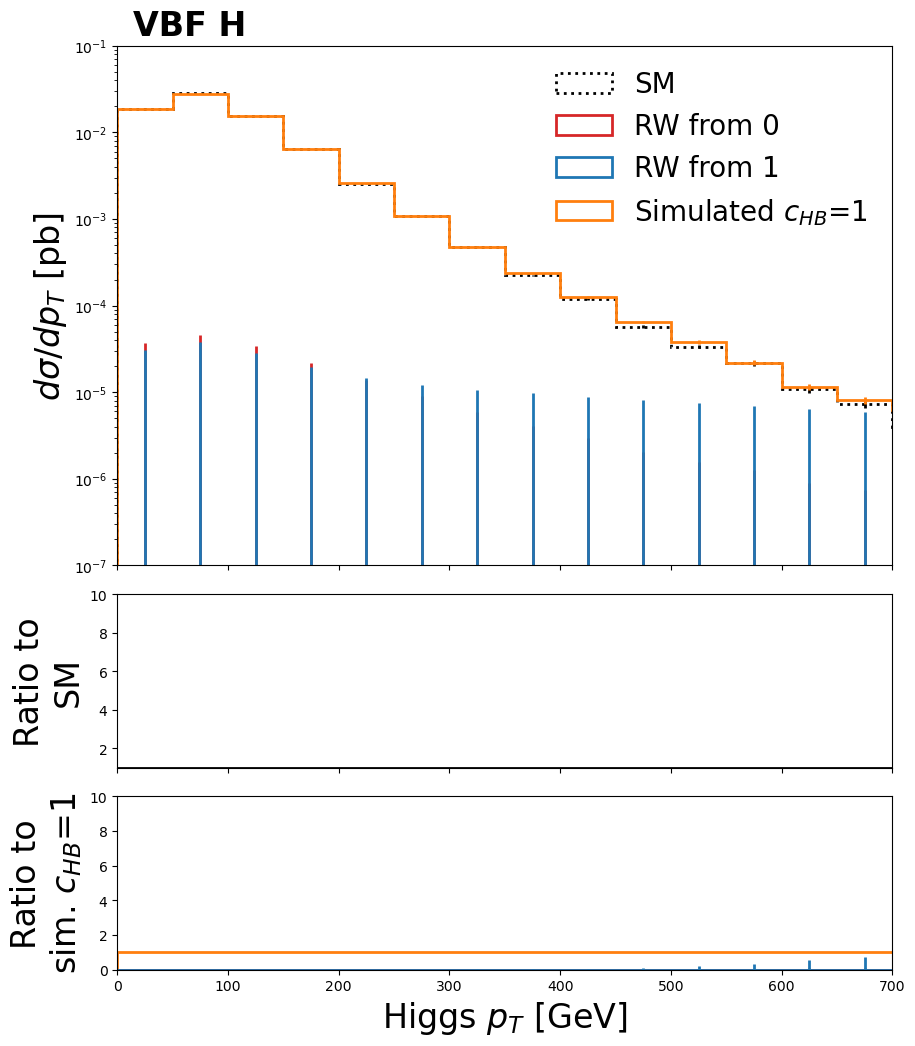

In [43]:
name=r'$d\sigma / dp_{T}$ [pb]'

samp3 = "VBF_SMEFTsim_topU3l_Direct_cHB"
output3 = util.load("coffea/"+samp3+".coffea")
d = output3['hpt']

plot_with_ratio('cHB', 1, name, h1, h2, d, rebin=10)

[[[ 1.         -0.03076172 -1.49999774 ... -1.5        -1.5
   -1.5       ]
  [-0.03076172  0.12304688 -0.03076172 ... -0.03076172 -0.03076172
   -0.03076172]
  [-1.49999774 -0.03076172  1.99999549 ...  0.5         0.5
    0.5       ]
  ...
  [-1.5        -0.03076172  0.5        ...  2.          0.5
    0.5       ]
  [-1.5        -0.03076172  0.5        ...  0.5         2.
    0.5       ]
  [-1.5        -0.03076172  0.5        ...  0.5         0.5
    2.        ]]

 [[ 1.         -0.03076172 -1.4999985  ... -1.5        -1.5
   -1.5       ]
  [-0.03076172  0.12304688 -0.03076172 ... -0.03076172 -0.03076172
   -0.03076172]
  [-1.4999985  -0.03076172  1.99999699 ...  0.5         0.5
    0.5       ]
  ...
  [-1.5        -0.03076172  0.5        ...  2.          0.5
    0.5       ]
  [-1.5        -0.03076172  0.5        ...  0.5         2.
    0.5       ]
  [-1.5        -0.03076172  0.5        ...  0.5         0.5
    2.        ]]

 [[ 1.         -0.03076172 -1.49999725 ... -1.5        -1.5


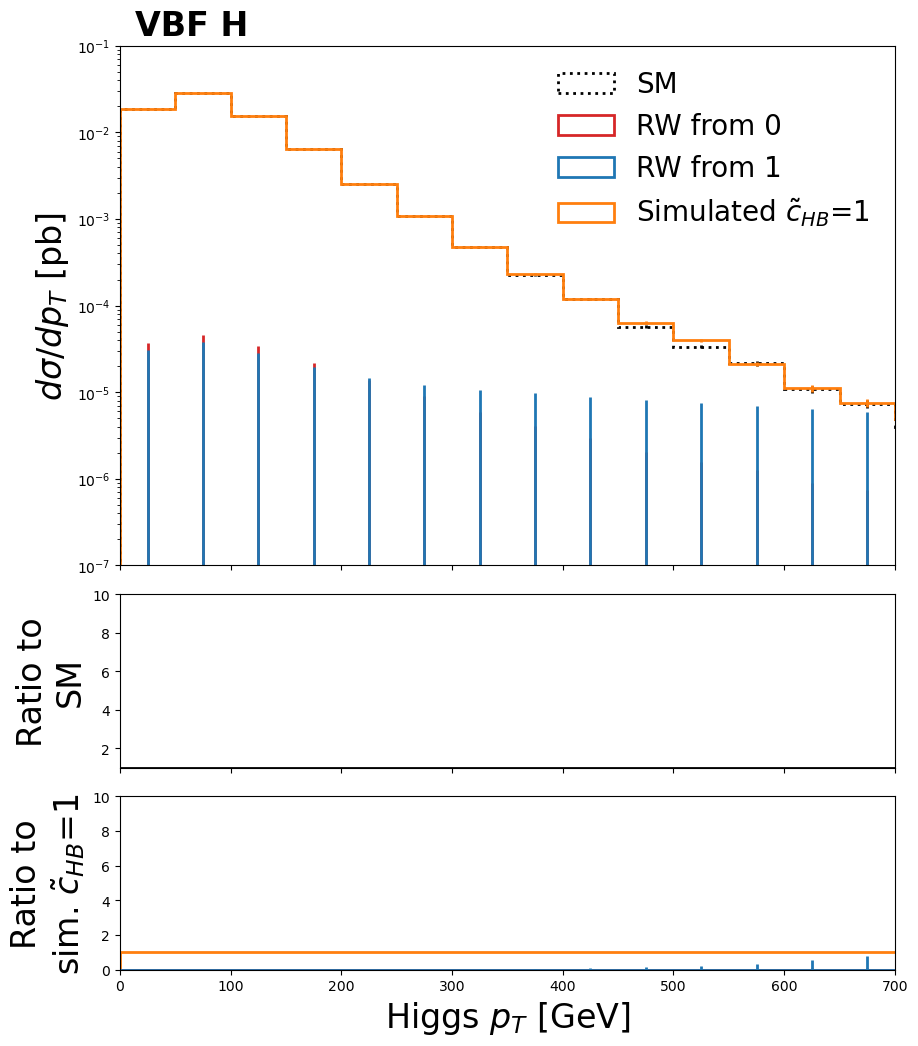

In [37]:
name=r'$d\sigma / dp_{T}$ [pb]'

samp3 = "VBF_SMEFTsim_topU3l_Direct_cHBtil"
output3 = util.load("coffea/"+samp3+".coffea")
d = output3['hpt']

plot_with_ratio('cHBtil', 1, name, h1, h2, d, rebin=10)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[9.98724674e+05 1.49956168e+06 8.19379829e+05 3.40272066e+05
 1.35398744e+05 5.73920494e+04 2.54558374e+04 1.18793462e+04
 6.25491811e+03 3.03046927e+03 1.78865818e+03 1.13922988e+03
 5.71495655e+02 3.91433648e+02 2.11252984e+02 1.75999716e+02
 1.25157032e+02 6.64924274e+01 5.09126068e+01 1.56328221e+01]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[7.80746993e+05 1.16955142e+06 6.46639038e+05 2.73107316e+05
 1.18778762e+05 5.41384789e+04 2.81990970e+04 1.61241277e+04
 1.04397734e+04 7.40471530e+03 5.30230377e+03 4.05461732e+03
 3.32289286e+03 2.62085776e+03 2.07983286e+03 1.87459236e+03
 1.34024408e+03 1.10649456e+03 9.90001538e+02 7.23480760e+02]


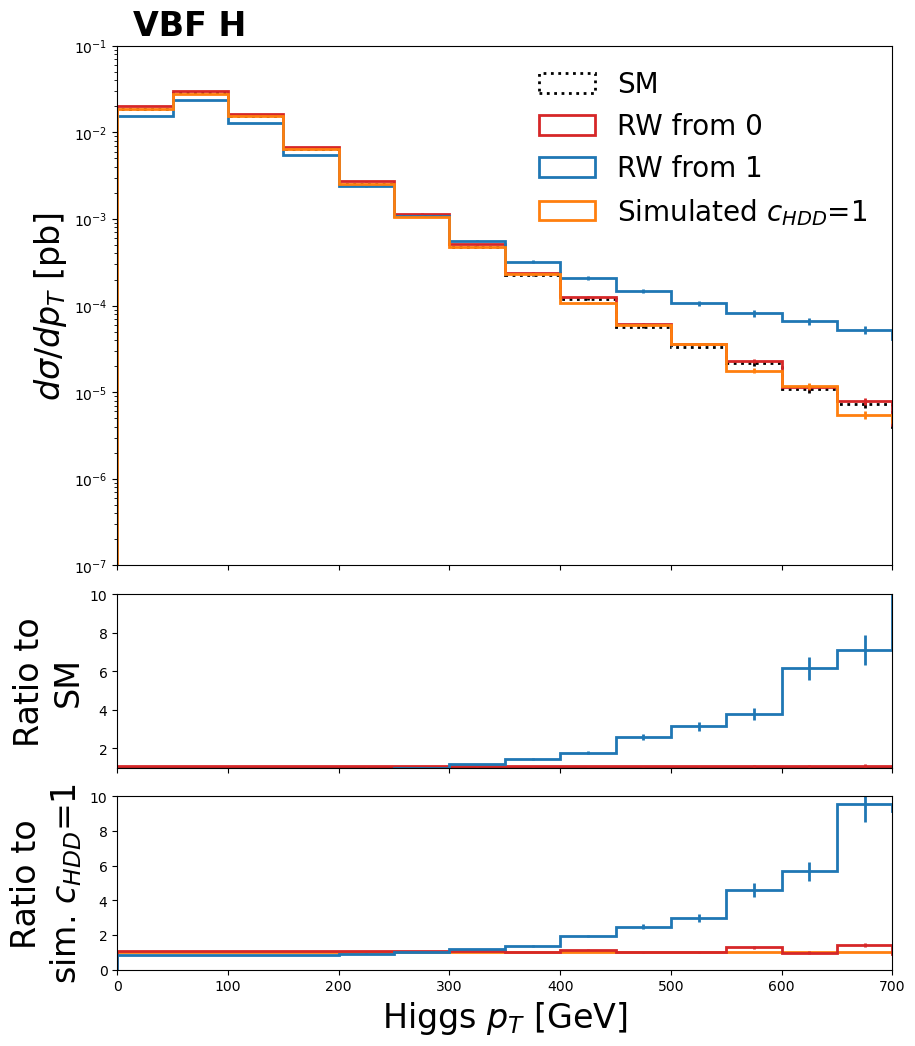

In [11]:
name=r'$d\sigma / dp_{T}$ [pb]'

samp3 = "VBF_SMEFTsim_topU3l_Direct_cHDD"
output3 = util.load("coffea/"+samp3+".coffea")
d = output3['hpt']

plot_with_ratio('cHDD', 1, name, h1, h2, d, rebin=10)

[1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[9.98724674e+05 1.49956168e+06 8.19379829e+05 3.40272066e+05
 1.35398744e+05 5.73920494e+04 2.54558374e+04 1.18793462e+04
 6.25491811e+03 3.03046927e+03 1.78865818e+03 1.13922988e+03
 5.71495655e+02 3.91433648e+02 2.11252984e+02 1.75999716e+02
 1.25157032e+02 6.64924274e+01 5.09126068e+01 1.56328221e+01]
[1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[7.80746993e+05 1.16955142e+06 6.46639038e+05 2.73107316e+05
 1.18778762e+05 5.41384789e+04 2.81990970e+04 1.61241277e+04
 1.04397734e+04 7.40471530e+03 5.30230377e+03 4.05461732e+03
 3.32289286e+03 2.62085776e+03 2.07983286e+03 1.87459236e+03
 1.34024408e+03 1.10649456e+03 9.90001538e+02 7.23480760e+02]


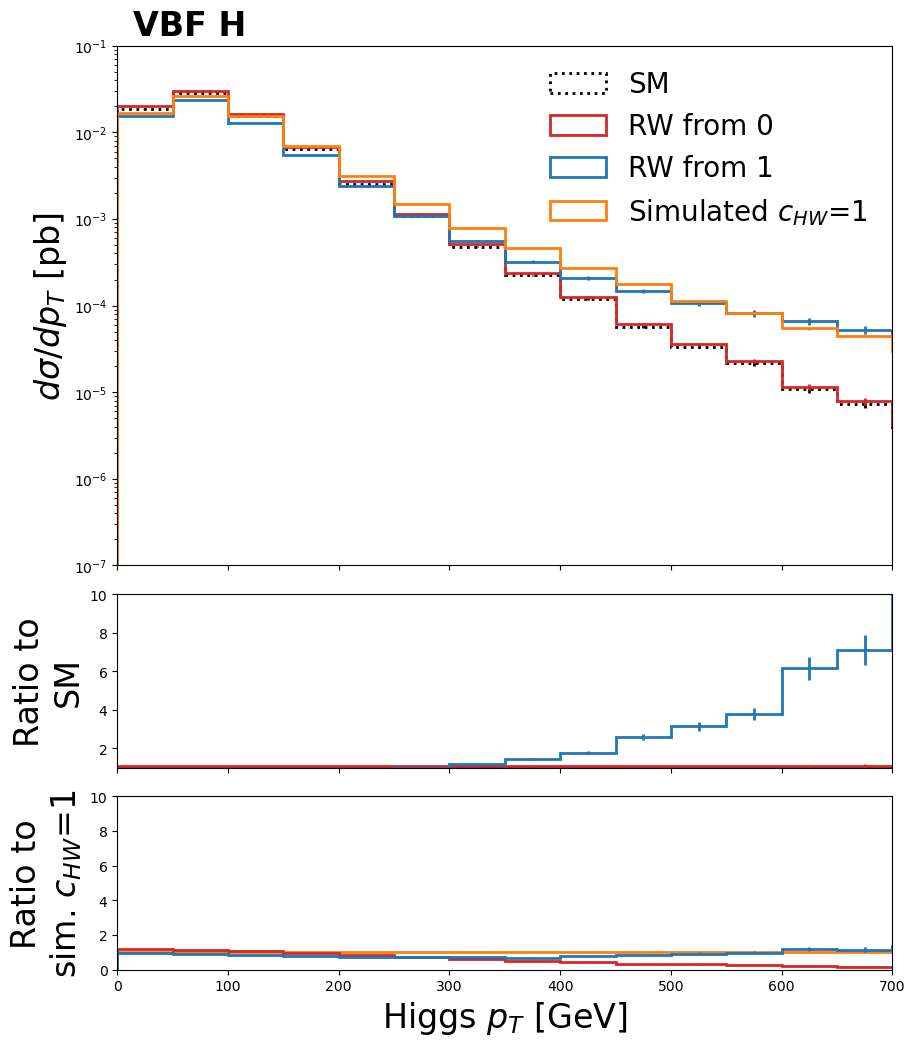

In [12]:
name=r'$d\sigma / dp_{T}$ [pb]'

samp3 = "VBF_SMEFTsim_topU3l_Direct_cHW"
output3 = util.load("coffea/"+samp3+".coffea")
d = output3['hpt']

plot_with_ratio('cHW', 1, name, h1, h2, d, rebin=10)

[1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[9.98724674e+05 1.49956168e+06 8.19379829e+05 3.40272066e+05
 1.35398744e+05 5.73920494e+04 2.54558374e+04 1.18793462e+04
 6.25491811e+03 3.03046927e+03 1.78865818e+03 1.13922988e+03
 5.71495655e+02 3.91433648e+02 2.11252984e+02 1.75999716e+02
 1.25157032e+02 6.64924274e+01 5.09126068e+01 1.56328221e+01]
[1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[7.80746993e+05 1.16955142e+06 6.46639038e+05 2.73107316e+05
 1.18778762e+05 5.41384789e+04 2.81990970e+04 1.61241277e+04
 1.04397734e+04 7.40471530e+03 5.30230377e+03 4.05461732e+03
 3.32289286e+03 2.62085776e+03 2.07983286e+03 1.87459236e+03
 1.34024408e+03 1.10649456e+03 9.90001538e+02 7.23480760e+02]


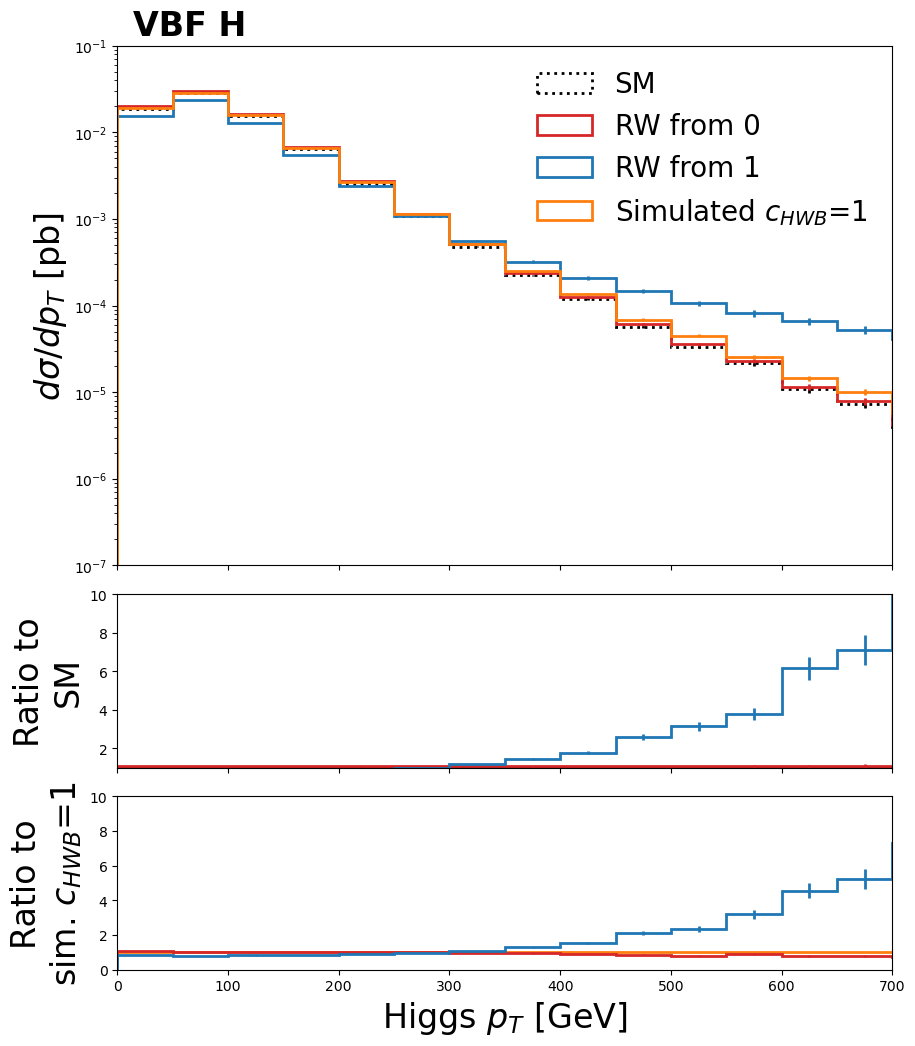

In [13]:
name=r'$d\sigma / dp_{T}$ [pb]'

samp3 = "VBF_SMEFTsim_topU3l_Direct_cHWB"
output3 = util.load("coffea/"+samp3+".coffea")
d = output3['hpt']

plot_with_ratio('cHWB', 1, name, h1, h2, d, rebin=10)

[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[9.98724674e+05 1.49956168e+06 8.19379829e+05 3.40272066e+05
 1.35398744e+05 5.73920494e+04 2.54558374e+04 1.18793462e+04
 6.25491811e+03 3.03046927e+03 1.78865818e+03 1.13922988e+03
 5.71495655e+02 3.91433648e+02 2.11252984e+02 1.75999716e+02
 1.25157032e+02 6.64924274e+01 5.09126068e+01 1.56328221e+01]
[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[7.80746993e+05 1.16955142e+06 6.46639038e+05 2.73107316e+05
 1.18778762e+05 5.41384789e+04 2.81990970e+04 1.61241277e+04
 1.04397734e+04 7.40471530e+03 5.30230377e+03 4.05461732e+03
 3.32289286e+03 2.62085776e+03 2.07983286e+03 1.87459236e+03
 1.34024408e+03 1.10649456e+03 9.90001538e+02 7.23480760e+02]


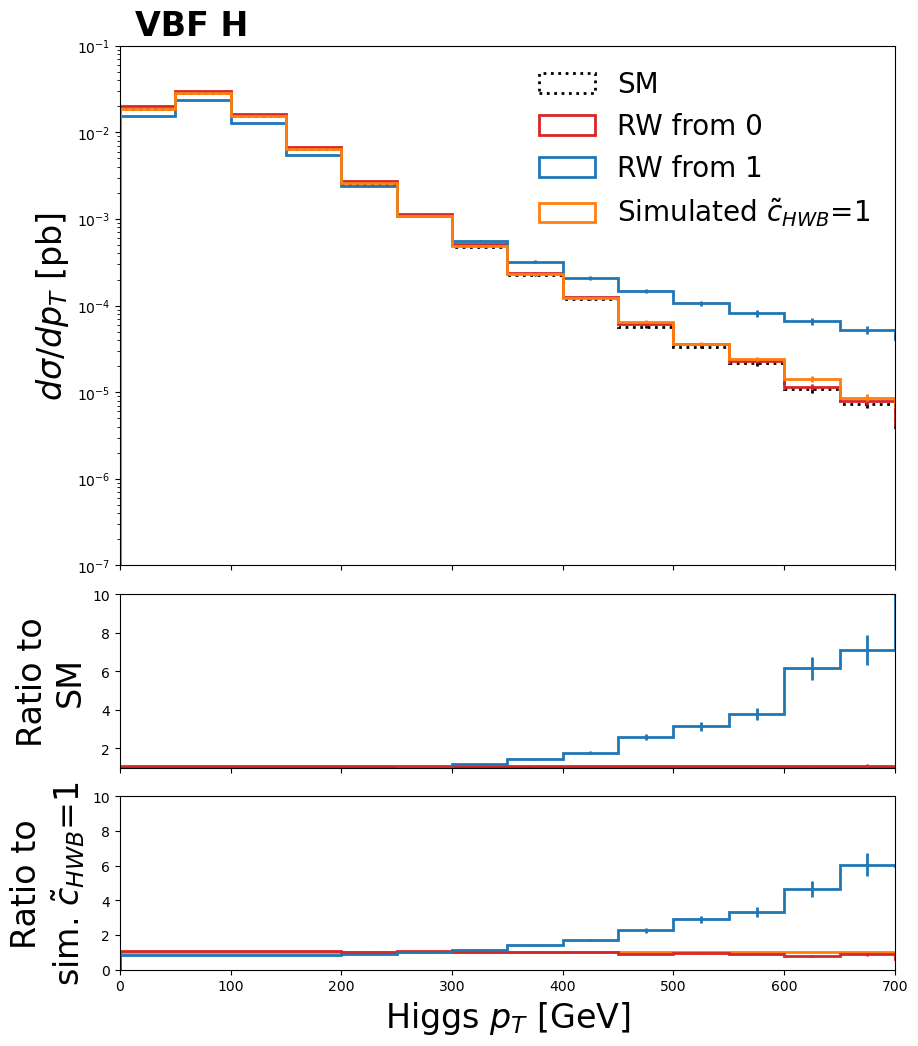

In [14]:
name=r'$d\sigma / dp_{T}$ [pb]'

samp3 = "VBF_SMEFTsim_topU3l_Direct_cHWBtil"
output3 = util.load("coffea/"+samp3+".coffea")
d = output3['hpt']

plot_with_ratio('cHWBtil', 1, name, h1, h2, d, rebin=10)

[1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[9.98724674e+05 1.49956168e+06 8.19379829e+05 3.40272066e+05
 1.35398744e+05 5.73920494e+04 2.54558374e+04 1.18793462e+04
 6.25491811e+03 3.03046927e+03 1.78865818e+03 1.13922988e+03
 5.71495655e+02 3.91433648e+02 2.11252984e+02 1.75999716e+02
 1.25157032e+02 6.64924274e+01 5.09126068e+01 1.56328221e+01]
[1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[7.80746993e+05 1.16955142e+06 6.46639038e+05 2.73107316e+05
 1.18778762e+05 5.41384789e+04 2.81990970e+04 1.61241277e+04
 1.04397734e+04 7.40471530e+03 5.30230377e+03 4.05461732e+03
 3.32289286e+03 2.62085776e+03 2.07983286e+03 1.87459236e+03
 1.34024408e+03 1.10649456e+03 9.90001538e+02 7.23480760e+02]


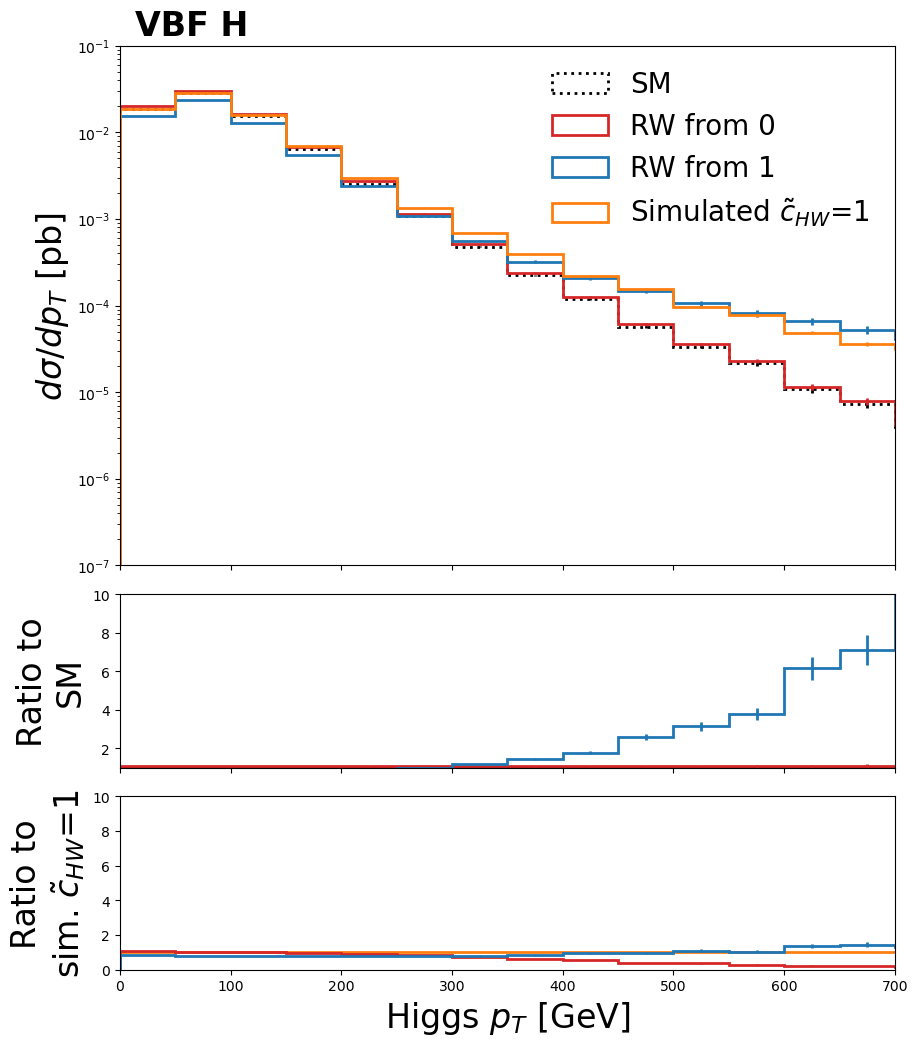

In [15]:
name=r'$d\sigma / dp_{T}$ [pb]'

samp3 = "VBF_SMEFTsim_topU3l_Direct_cHWtil"
output3 = util.load("coffea/"+samp3+".coffea")
d = output3['hpt']

plot_with_ratio('cHWtil', 1, name, h1, h2, d, rebin=10)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[9.98724674e+05 1.49956168e+06 8.19379829e+05 3.40272066e+05
 1.35398744e+05 5.73920494e+04 2.54558374e+04 1.18793462e+04
 6.25491811e+03 3.03046927e+03 1.78865818e+03 1.13922988e+03
 5.71495655e+02 3.91433648e+02 2.11252984e+02 1.75999716e+02
 1.25157032e+02 6.64924274e+01 5.09126068e+01 1.56328221e+01]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[7.80746993e+05 1.16955142e+06 6.46639038e+05 2.73107316e+05
 1.18778762e+05 5.41384789e+04 2.81990970e+04 1.61241277e+04
 1.04397734e+04 7.40471530e+03 5.30230377e+03 4.05461732e+03
 3.32289286e+03 2.62085776e+03 2.07983286e+03 1.87459236e+03
 1.34024408e+03 1.10649456e+03 9.90001538e+02 7.23480760e+02]


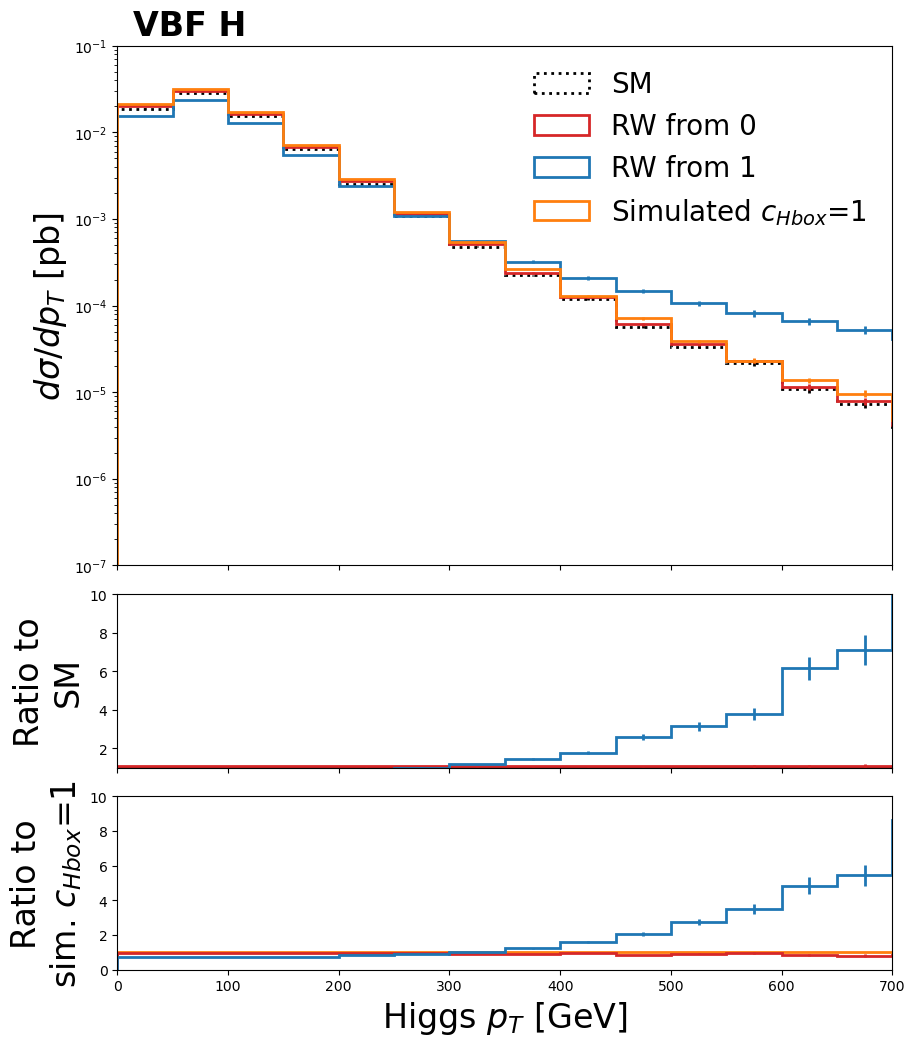

In [16]:
name=r'$d\sigma / dp_{T}$ [pb]'

samp3 = "VBF_SMEFTsim_topU3l_Direct_cHbox"
output3 = util.load("coffea/"+samp3+".coffea")
d = output3['hpt']


plot_with_ratio('cHbox', 1, name, h1, h2, d, rebin=10)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[9.98724674e+05 1.49956168e+06 8.19379829e+05 3.40272066e+05
 1.35398744e+05 5.73920494e+04 2.54558374e+04 1.18793462e+04
 6.25491811e+03 3.03046927e+03 1.78865818e+03 1.13922988e+03
 5.71495655e+02 3.91433648e+02 2.11252984e+02 1.75999716e+02
 1.25157032e+02 6.64924274e+01 5.09126068e+01 1.56328221e+01]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[7.80746993e+05 1.16955142e+06 6.46639038e+05 2.73107316e+05
 1.18778762e+05 5.41384789e+04 2.81990970e+04 1.61241277e+04
 1.04397734e+04 7.40471530e+03 5.30230377e+03 4.05461732e+03
 3.32289286e+03 2.62085776e+03 2.07983286e+03 1.87459236e+03
 1.34024408e+03 1.10649456e+03 9.90001538e+02 7.23480760e+02]


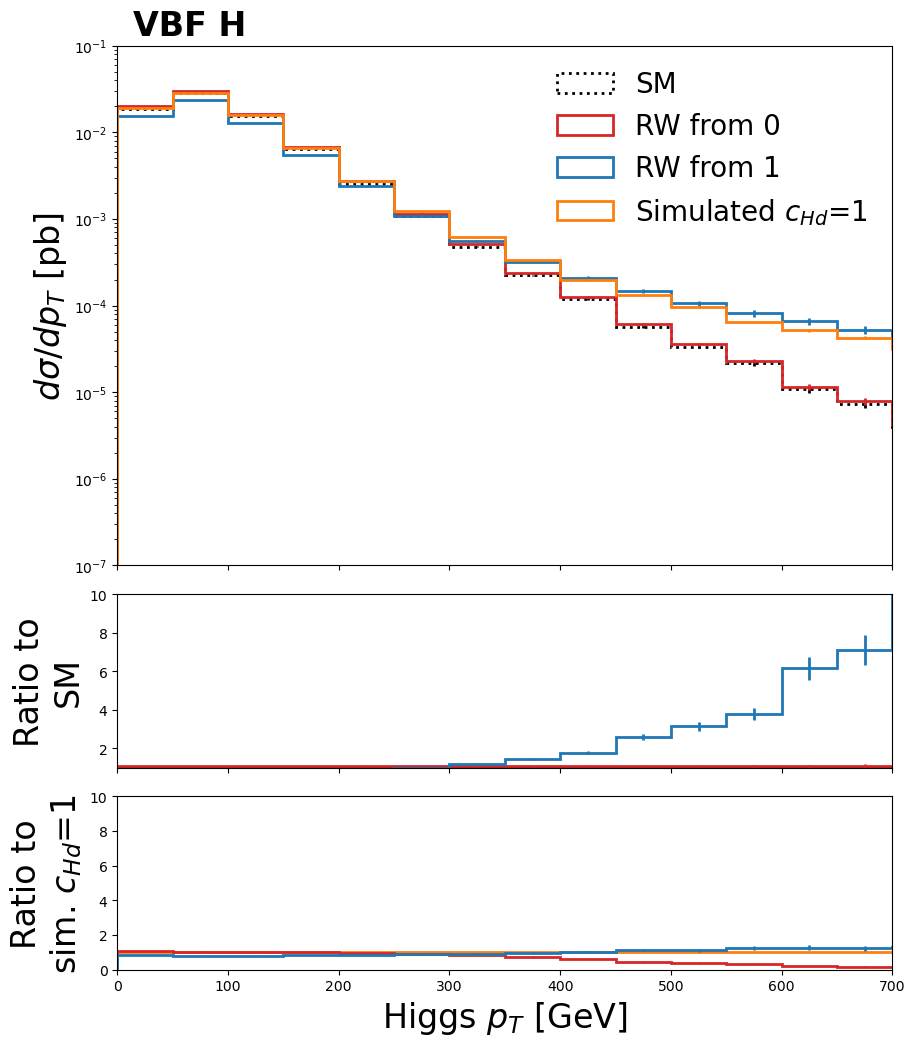

In [17]:
name=r'$d\sigma / dp_{T}$ [pb]'

samp3 = "VBF_SMEFTsim_topU3l_Direct_cHd"
output3 = util.load("coffea/"+samp3+".coffea")
d = output3['hpt']

plot_with_ratio('cHd', 1, name, h1, h2, d, rebin=10)

[1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[9.98724674e+05 1.49956168e+06 8.19379829e+05 3.40272066e+05
 1.35398744e+05 5.73920494e+04 2.54558374e+04 1.18793462e+04
 6.25491811e+03 3.03046927e+03 1.78865818e+03 1.13922988e+03
 5.71495655e+02 3.91433648e+02 2.11252984e+02 1.75999716e+02
 1.25157032e+02 6.64924274e+01 5.09126068e+01 1.56328221e+01]
[1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[7.80746993e+05 1.16955142e+06 6.46639038e+05 2.73107316e+05
 1.18778762e+05 5.41384789e+04 2.81990970e+04 1.61241277e+04
 1.04397734e+04 7.40471530e+03 5.30230377e+03 4.05461732e+03
 3.32289286e+03 2.62085776e+03 2.07983286e+03 1.87459236e+03
 1.34024408e+03 1.10649456e+03 9.90001538e+02 7.23480760e+02]


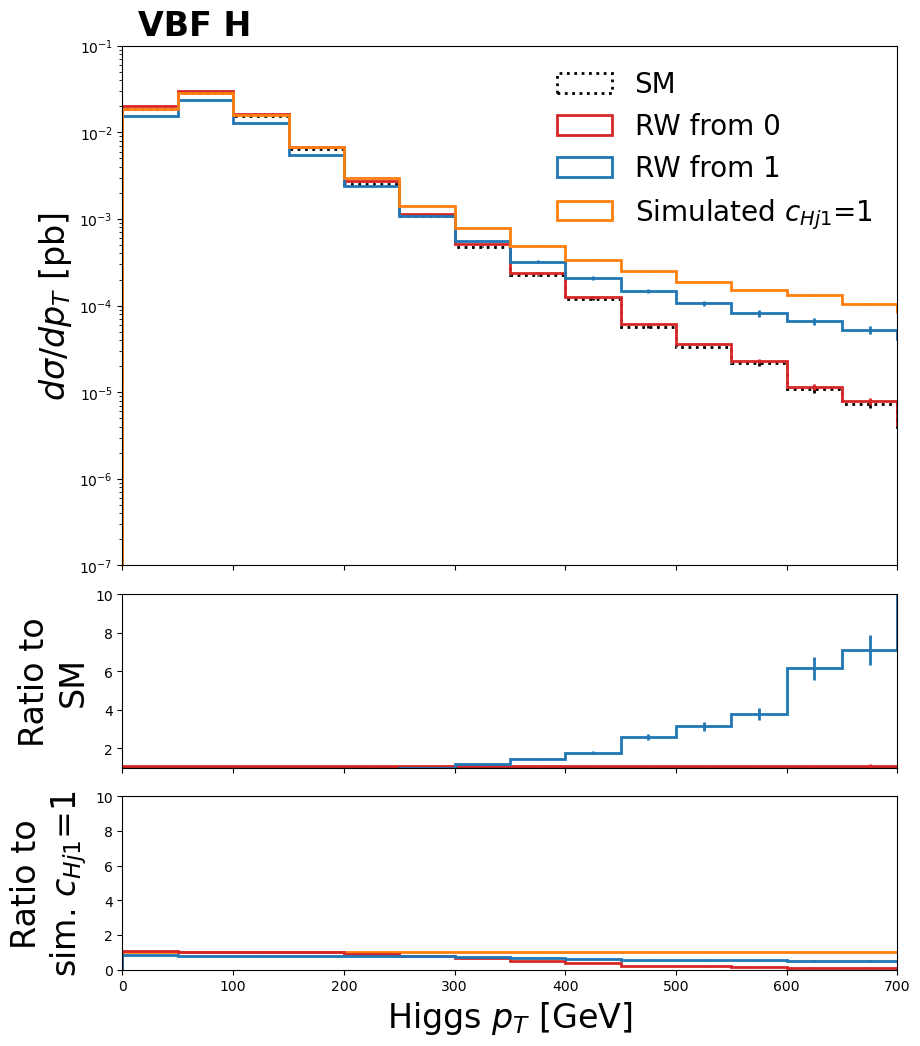

In [18]:
name=r'$d\sigma / dp_{T}$ [pb]'

samp3 = "VBF_SMEFTsim_topU3l_Direct_cHj1"
output3 = util.load("coffea/"+samp3+".coffea")
d = output3['hpt']

plot_with_ratio('cHj1', 1, name, h1, h2, d, rebin=10)

[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[9.98724674e+05 1.49956168e+06 8.19379829e+05 3.40272066e+05
 1.35398744e+05 5.73920494e+04 2.54558374e+04 1.18793462e+04
 6.25491811e+03 3.03046927e+03 1.78865818e+03 1.13922988e+03
 5.71495655e+02 3.91433648e+02 2.11252984e+02 1.75999716e+02
 1.25157032e+02 6.64924274e+01 5.09126068e+01 1.56328221e+01]
[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[7.80746993e+05 1.16955142e+06 6.46639038e+05 2.73107316e+05
 1.18778762e+05 5.41384789e+04 2.81990970e+04 1.61241277e+04
 1.04397734e+04 7.40471530e+03 5.30230377e+03 4.05461732e+03
 3.32289286e+03 2.62085776e+03 2.07983286e+03 1.87459236e+03
 1.34024408e+03 1.10649456e+03 9.90001538e+02 7.23480760e+02]


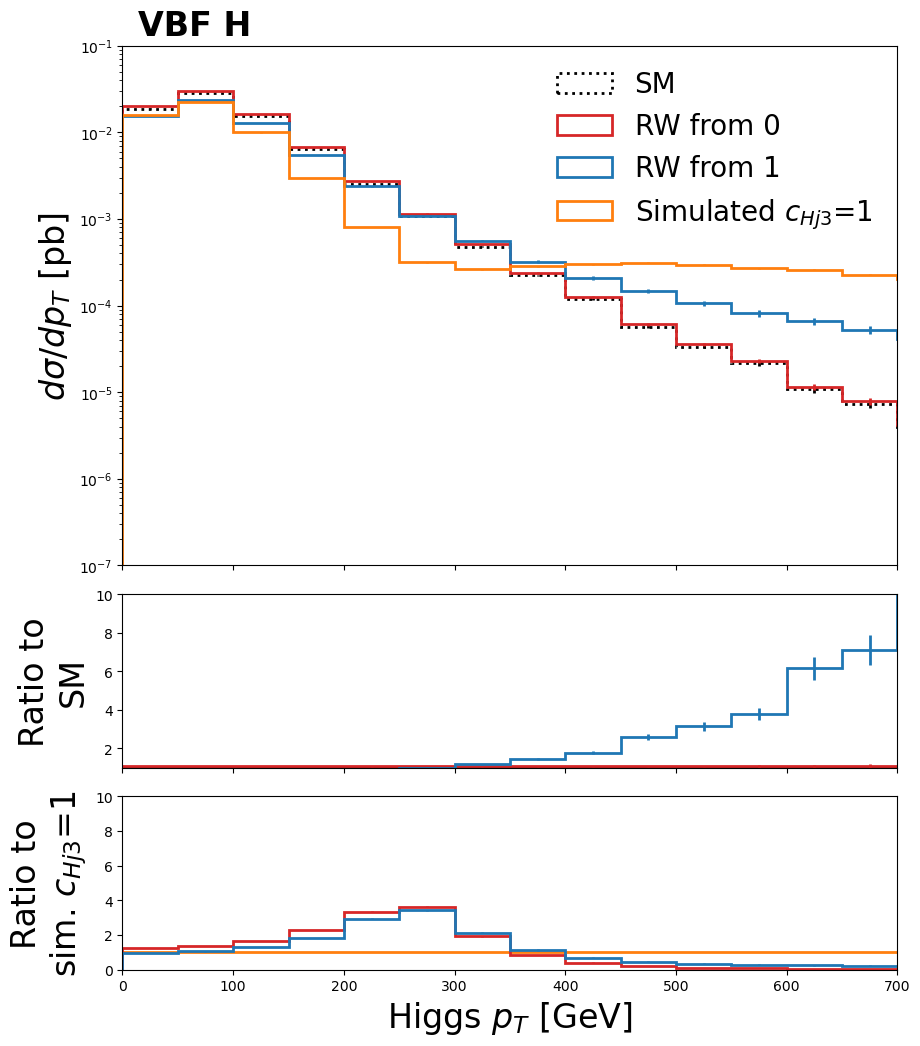

In [19]:
name=r'$d\sigma / dp_{T}$ [pb]'

samp3 = "VBF_SMEFTsim_topU3l_Direct_cHj3"
output3 = util.load("coffea/"+samp3+".coffea")
d = output3['hpt']

plot_with_ratio('cHj3', 1, name, h1, h2, d, rebin=10)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[9.98724674e+05 1.49956168e+06 8.19379829e+05 3.40272066e+05
 1.35398744e+05 5.73920494e+04 2.54558374e+04 1.18793462e+04
 6.25491811e+03 3.03046927e+03 1.78865818e+03 1.13922988e+03
 5.71495655e+02 3.91433648e+02 2.11252984e+02 1.75999716e+02
 1.25157032e+02 6.64924274e+01 5.09126068e+01 1.56328221e+01]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[7.80746993e+05 1.16955142e+06 6.46639038e+05 2.73107316e+05
 1.18778762e+05 5.41384789e+04 2.81990970e+04 1.61241277e+04
 1.04397734e+04 7.40471530e+03 5.30230377e+03 4.05461732e+03
 3.32289286e+03 2.62085776e+03 2.07983286e+03 1.87459236e+03
 1.34024408e+03 1.10649456e+03 9.90001538e+02 7.23480760e+02]


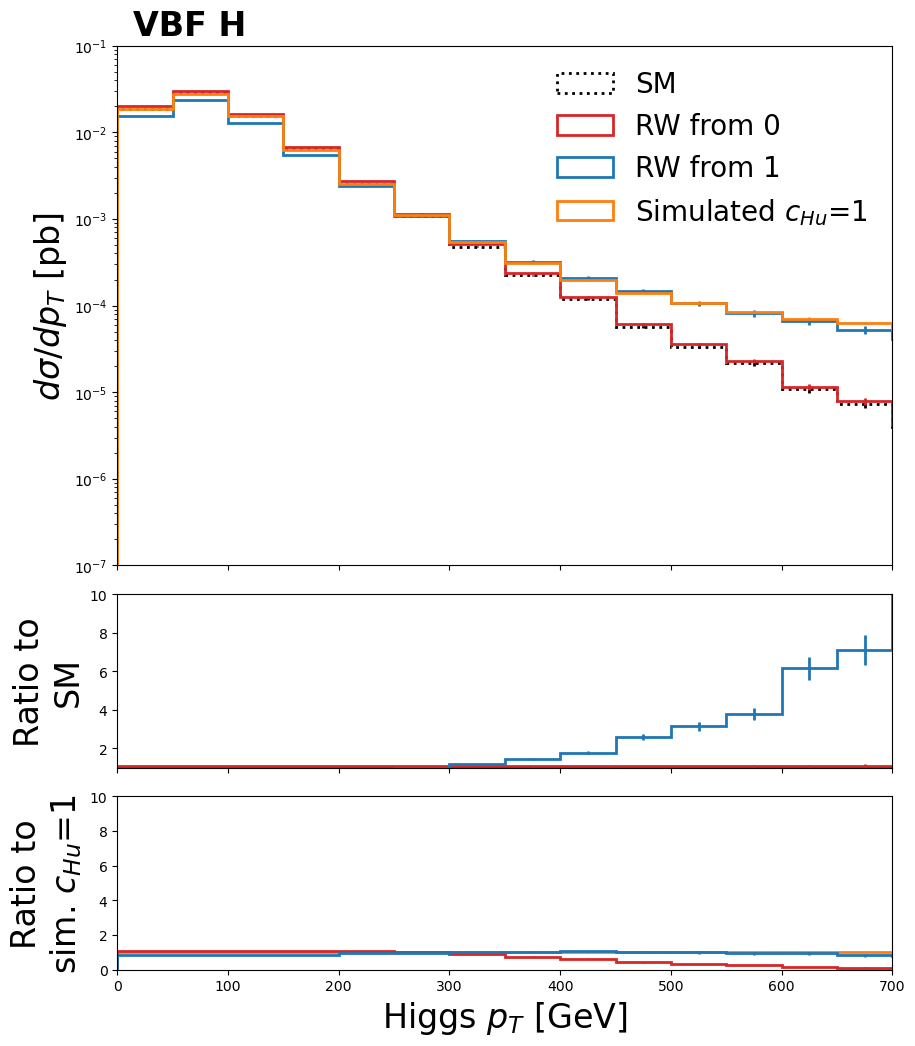

In [20]:
name=r'$d\sigma / dp_{T}$ [pb]'

samp3 = "VBF_SMEFTsim_topU3l_Direct_cHu"
output3 = util.load("coffea/"+samp3+".coffea")
d = output3['hpt']

plot_with_ratio('cHu', 1, name, h1, h2, d, rebin=10)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[9.98724674e+05 1.49956168e+06 8.19379829e+05 3.40272066e+05
 1.35398744e+05 5.73920494e+04 2.54558374e+04 1.18793462e+04
 6.25491811e+03 3.03046927e+03 1.78865818e+03 1.13922988e+03
 5.71495655e+02 3.91433648e+02 2.11252984e+02 1.75999716e+02
 1.25157032e+02 6.64924274e+01 5.09126068e+01 1.56328221e+01]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[7.80746993e+05 1.16955142e+06 6.46639038e+05 2.73107316e+05
 1.18778762e+05 5.41384789e+04 2.81990970e+04 1.61241277e+04
 1.04397734e+04 7.40471530e+03 5.30230377e+03 4.05461732e+03
 3.32289286e+03 2.62085776e+03 2.07983286e+03 1.87459236e+03
 1.34024408e+03 1.10649456e+03 9.90001538e+02 7.23480760e+02]


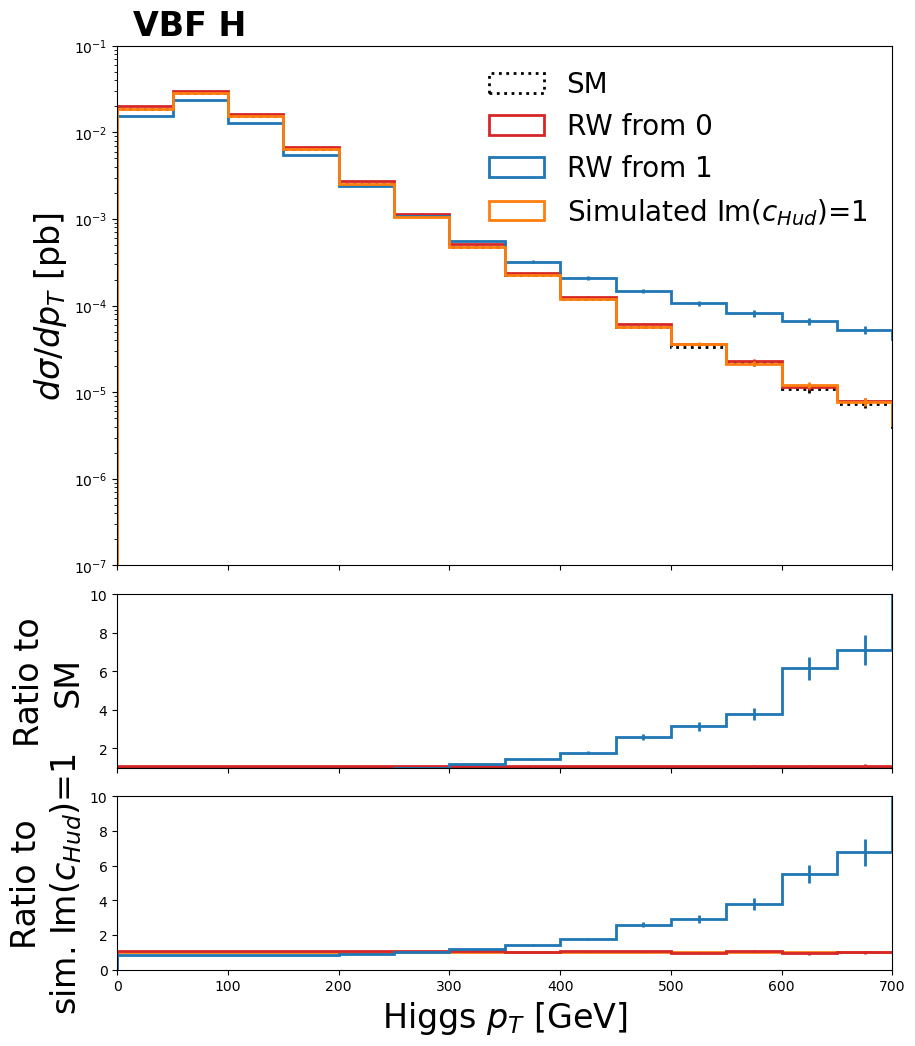

In [21]:
name=r'$d\sigma / dp_{T}$ [pb]'

samp3 = "VBF_SMEFTsim_topU3l_Direct_cHudIm"
output3 = util.load("coffea/"+samp3+".coffea")
d = output3['hpt']

plot_with_ratio('cHudIm', 1, name, h1, h2, d, rebin=10)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[9.98724674e+05 1.49956168e+06 8.19379829e+05 3.40272066e+05
 1.35398744e+05 5.73920494e+04 2.54558374e+04 1.18793462e+04
 6.25491811e+03 3.03046927e+03 1.78865818e+03 1.13922988e+03
 5.71495655e+02 3.91433648e+02 2.11252984e+02 1.75999716e+02
 1.25157032e+02 6.64924274e+01 5.09126068e+01 1.56328221e+01]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[7.80746993e+05 1.16955142e+06 6.46639038e+05 2.73107316e+05
 1.18778762e+05 5.41384789e+04 2.81990970e+04 1.61241277e+04
 1.04397734e+04 7.40471530e+03 5.30230377e+03 4.05461732e+03
 3.32289286e+03 2.62085776e+03 2.07983286e+03 1.87459236e+03
 1.34024408e+03 1.10649456e+03 9.90001538e+02 7.23480760e+02]


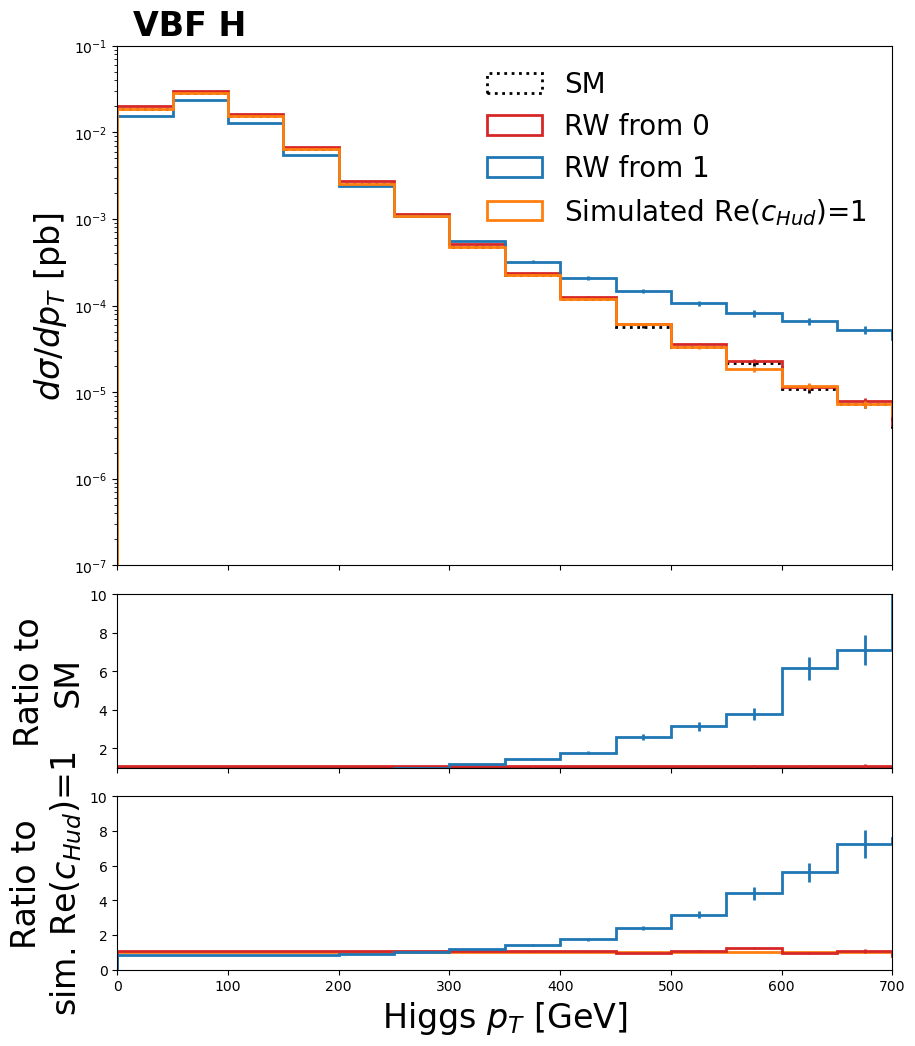

In [22]:
name=r'$d\sigma / dp_{T}$ [pb]'

samp3 = "VBF_SMEFTsim_topU3l_Direct_cHudRe"
output3 = util.load("coffea/"+samp3+".coffea")
d = output3['hpt']

plot_with_ratio('cHudRe', 1, name, h1, h2, d, rebin=10)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[9.98724674e+05 1.49956168e+06 8.19379829e+05 3.40272066e+05
 1.35398744e+05 5.73920494e+04 2.54558374e+04 1.18793462e+04
 6.25491811e+03 3.03046927e+03 1.78865818e+03 1.13922988e+03
 5.71495655e+02 3.91433648e+02 2.11252984e+02 1.75999716e+02
 1.25157032e+02 6.64924274e+01 5.09126068e+01 1.56328221e+01]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[7.80746993e+05 1.16955142e+06 6.46639038e+05 2.73107316e+05
 1.18778762e+05 5.41384789e+04 2.81990970e+04 1.61241277e+04
 1.04397734e+04 7.40471530e+03 5.30230377e+03 4.05461732e+03
 3.32289286e+03 2.62085776e+03 2.07983286e+03 1.87459236e+03
 1.34024408e+03 1.10649456e+03 9.90001538e+02 7.23480760e+02]


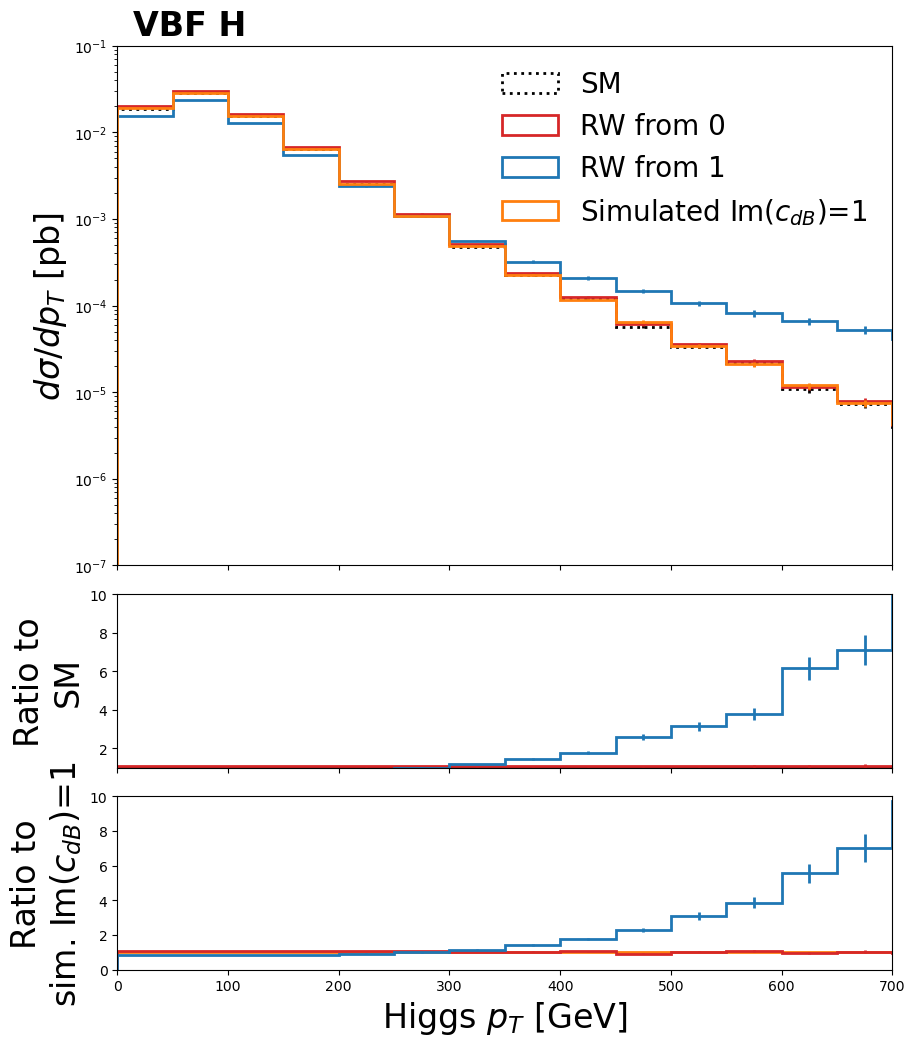

In [23]:
name=r'$d\sigma / dp_{T}$ [pb]'

samp3 = "VBF_SMEFTsim_topU3l_Direct_cdBIm"
output3 = util.load("coffea/"+samp3+".coffea")
d = output3['hpt']

plot_with_ratio('cdBIm', 1, name, h1, h2, d, rebin=10)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[9.98724674e+05 1.49956168e+06 8.19379829e+05 3.40272066e+05
 1.35398744e+05 5.73920494e+04 2.54558374e+04 1.18793462e+04
 6.25491811e+03 3.03046927e+03 1.78865818e+03 1.13922988e+03
 5.71495655e+02 3.91433648e+02 2.11252984e+02 1.75999716e+02
 1.25157032e+02 6.64924274e+01 5.09126068e+01 1.56328221e+01]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[7.80746993e+05 1.16955142e+06 6.46639038e+05 2.73107316e+05
 1.18778762e+05 5.41384789e+04 2.81990970e+04 1.61241277e+04
 1.04397734e+04 7.40471530e+03 5.30230377e+03 4.05461732e+03
 3.32289286e+03 2.62085776e+03 2.07983286e+03 1.87459236e+03
 1.34024408e+03 1.10649456e+03 9.90001538e+02 7.23480760e+02]


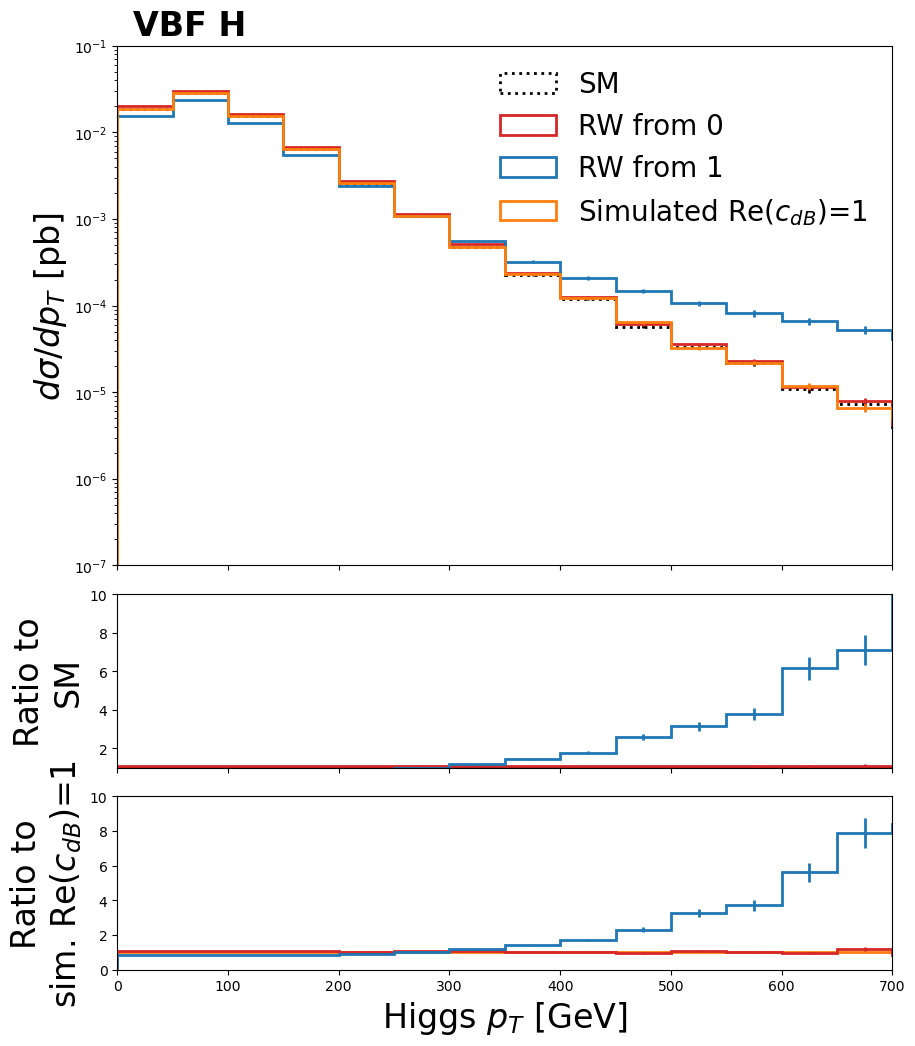

In [24]:
name=r'$d\sigma / dp_{T}$ [pb]'

samp3 = "VBF_SMEFTsim_topU3l_Direct_cdBRe"
output3 = util.load("coffea/"+samp3+".coffea")
d = output3['hpt']

plot_with_ratio('cdBRe', 1, name, h1, h2, d, rebin=10)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[9.98724674e+05 1.49956168e+06 8.19379829e+05 3.40272066e+05
 1.35398744e+05 5.73920494e+04 2.54558374e+04 1.18793462e+04
 6.25491811e+03 3.03046927e+03 1.78865818e+03 1.13922988e+03
 5.71495655e+02 3.91433648e+02 2.11252984e+02 1.75999716e+02
 1.25157032e+02 6.64924274e+01 5.09126068e+01 1.56328221e+01]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[7.80746993e+05 1.16955142e+06 6.46639038e+05 2.73107316e+05
 1.18778762e+05 5.41384789e+04 2.81990970e+04 1.61241277e+04
 1.04397734e+04 7.40471530e+03 5.30230377e+03 4.05461732e+03
 3.32289286e+03 2.62085776e+03 2.07983286e+03 1.87459236e+03
 1.34024408e+03 1.10649456e+03 9.90001538e+02 7.23480760e+02]


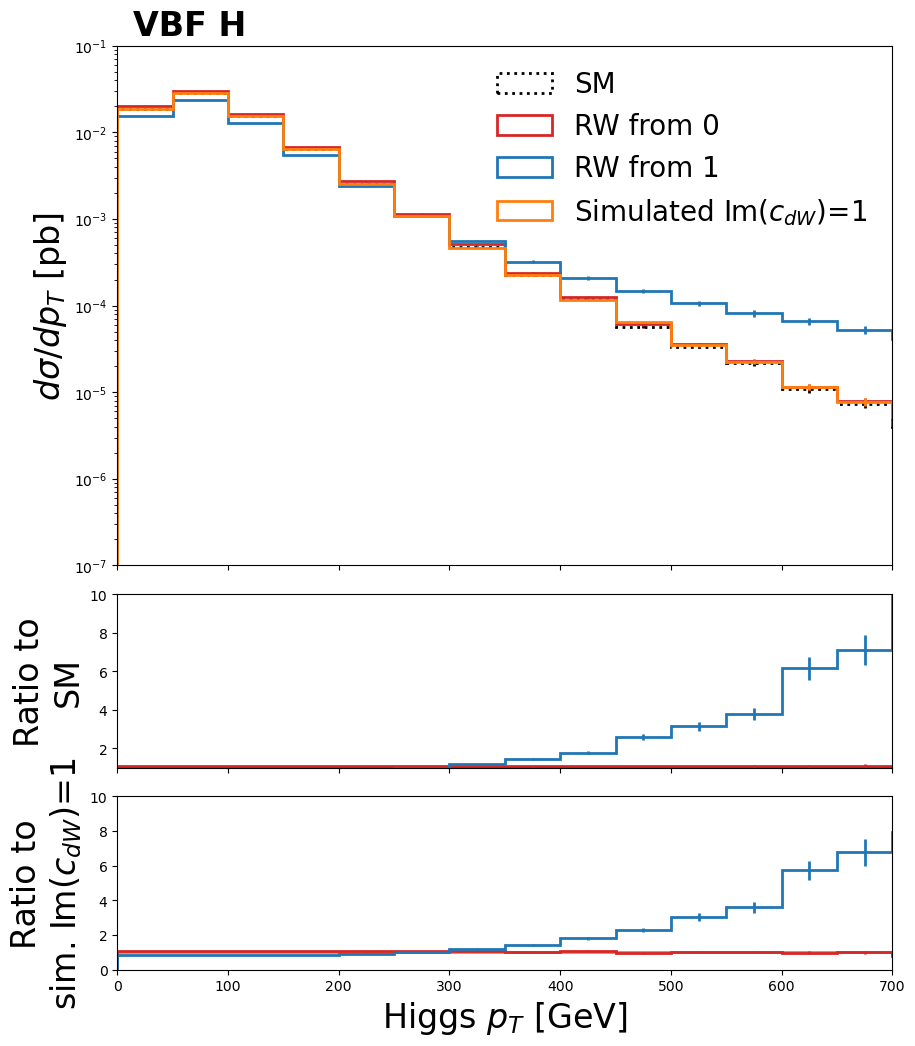

In [25]:
name=r'$d\sigma / dp_{T}$ [pb]'

samp3 = "VBF_SMEFTsim_topU3l_Direct_cdWIm"
output3 = util.load("coffea/"+samp3+".coffea")
d = output3['hpt']

plot_with_ratio('cdWIm', 1, name, h1, h2, d, rebin=10)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[9.98724674e+05 1.49956168e+06 8.19379829e+05 3.40272066e+05
 1.35398744e+05 5.73920494e+04 2.54558374e+04 1.18793462e+04
 6.25491811e+03 3.03046927e+03 1.78865818e+03 1.13922988e+03
 5.71495655e+02 3.91433648e+02 2.11252984e+02 1.75999716e+02
 1.25157032e+02 6.64924274e+01 5.09126068e+01 1.56328221e+01]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[7.80746993e+05 1.16955142e+06 6.46639038e+05 2.73107316e+05
 1.18778762e+05 5.41384789e+04 2.81990970e+04 1.61241277e+04
 1.04397734e+04 7.40471530e+03 5.30230377e+03 4.05461732e+03
 3.32289286e+03 2.62085776e+03 2.07983286e+03 1.87459236e+03
 1.34024408e+03 1.10649456e+03 9.90001538e+02 7.23480760e+02]


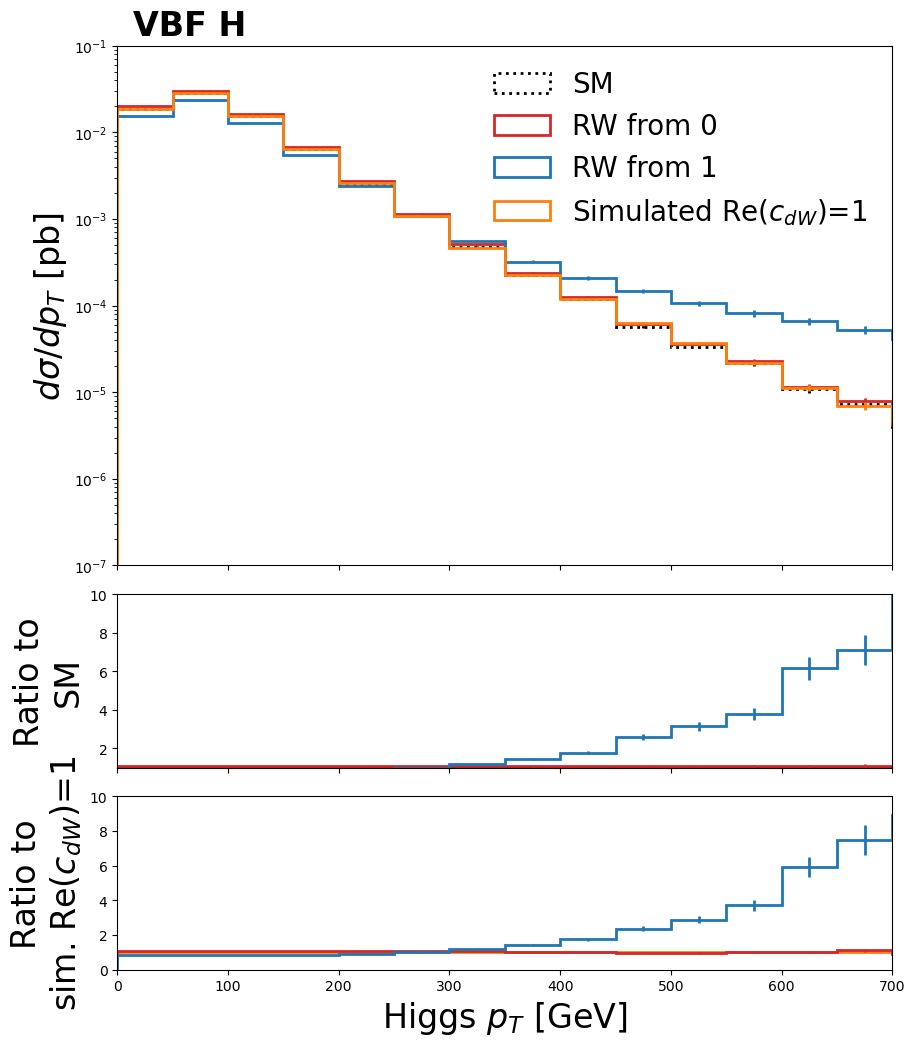

In [26]:
name=r'$d\sigma / dp_{T}$ [pb]'

samp3 = "VBF_SMEFTsim_topU3l_Direct_cdWRe"
output3 = util.load("coffea/"+samp3+".coffea")
d = output3['hpt']

plot_with_ratio('cdWRe', 1, name, h1, h2, d, rebin=10)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[9.98724674e+05 1.49956168e+06 8.19379829e+05 3.40272066e+05
 1.35398744e+05 5.73920494e+04 2.54558374e+04 1.18793462e+04
 6.25491811e+03 3.03046927e+03 1.78865818e+03 1.13922988e+03
 5.71495655e+02 3.91433648e+02 2.11252984e+02 1.75999716e+02
 1.25157032e+02 6.64924274e+01 5.09126068e+01 1.56328221e+01]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[7.80746993e+05 1.16955142e+06 6.46639038e+05 2.73107316e+05
 1.18778762e+05 5.41384789e+04 2.81990970e+04 1.61241277e+04
 1.04397734e+04 7.40471530e+03 5.30230377e+03 4.05461732e+03
 3.32289286e+03 2.62085776e+03 2.07983286e+03 1.87459236e+03
 1.34024408e+03 1.10649456e+03 9.90001538e+02 7.23480760e+02]


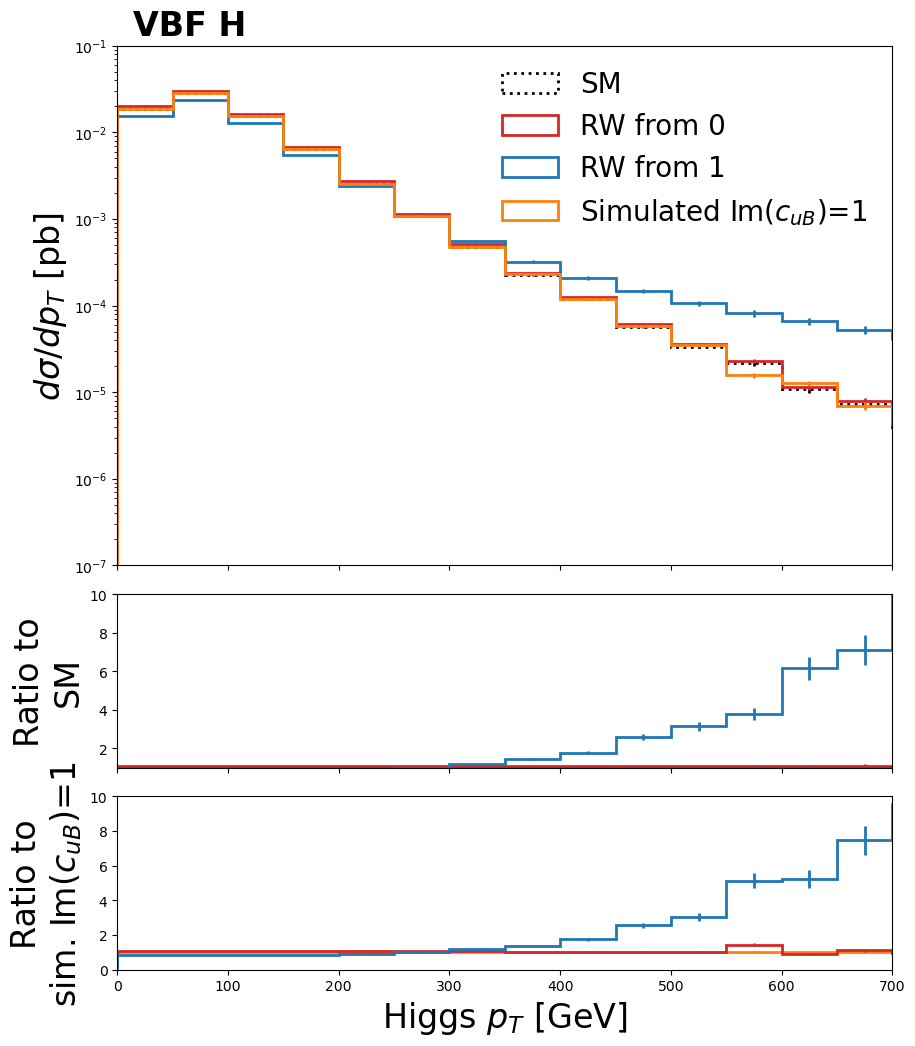

In [27]:
name=r'$d\sigma / dp_{T}$ [pb]'

samp3 = "VBF_SMEFTsim_topU3l_Direct_cuBIm"
output3 = util.load("coffea/"+samp3+".coffea")
d = output3['hpt']

plot_with_ratio('cuBIm', 1, name, h1, h2, d, rebin=10)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[9.98724674e+05 1.49956168e+06 8.19379829e+05 3.40272066e+05
 1.35398744e+05 5.73920494e+04 2.54558374e+04 1.18793462e+04
 6.25491811e+03 3.03046927e+03 1.78865818e+03 1.13922988e+03
 5.71495655e+02 3.91433648e+02 2.11252984e+02 1.75999716e+02
 1.25157032e+02 6.64924274e+01 5.09126068e+01 1.56328221e+01]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[7.80746993e+05 1.16955142e+06 6.46639038e+05 2.73107316e+05
 1.18778762e+05 5.41384789e+04 2.81990970e+04 1.61241277e+04
 1.04397734e+04 7.40471530e+03 5.30230377e+03 4.05461732e+03
 3.32289286e+03 2.62085776e+03 2.07983286e+03 1.87459236e+03
 1.34024408e+03 1.10649456e+03 9.90001538e+02 7.23480760e+02]


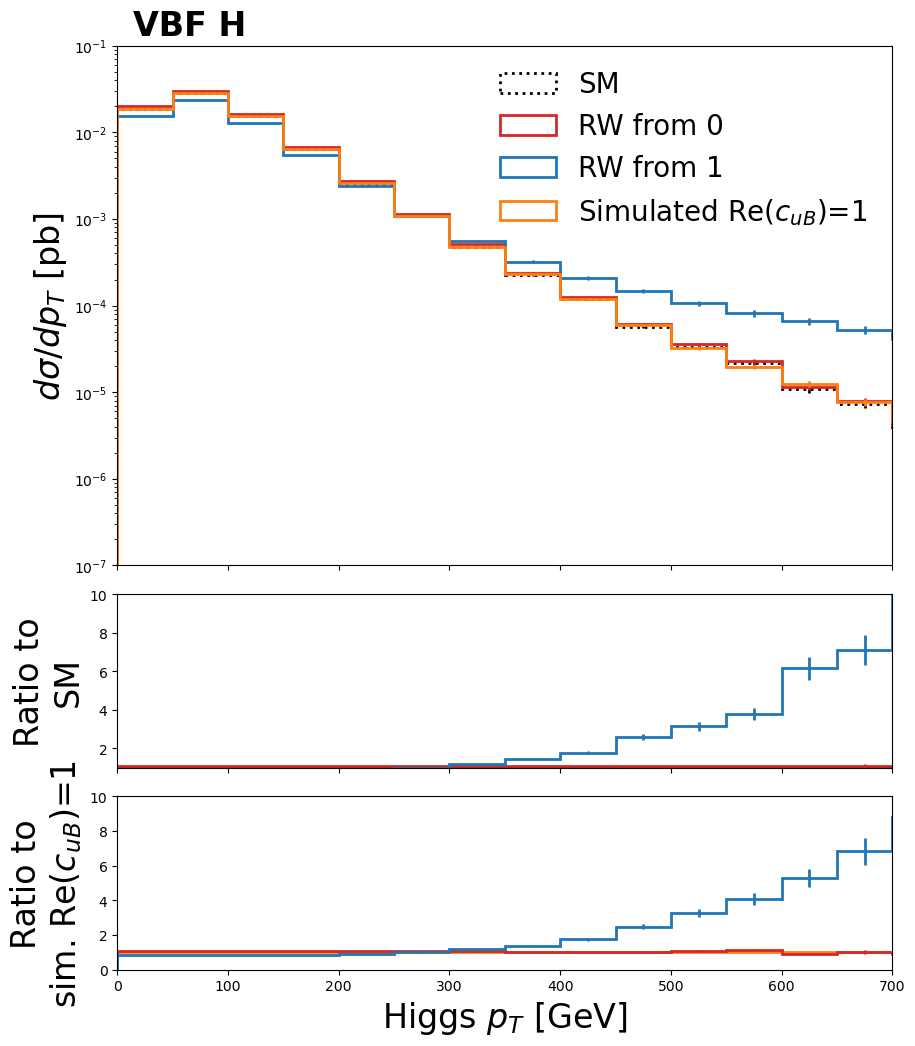

In [28]:
name=r'$d\sigma / dp_{T}$ [pb]'

samp3 = "VBF_SMEFTsim_topU3l_Direct_cuBRe"
output3 = util.load("coffea/"+samp3+".coffea")
d = output3['hpt']

plot_with_ratio('cuBRe', 1, name, h1, h2, d, rebin=10)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[9.98724674e+05 1.49956168e+06 8.19379829e+05 3.40272066e+05
 1.35398744e+05 5.73920494e+04 2.54558374e+04 1.18793462e+04
 6.25491811e+03 3.03046927e+03 1.78865818e+03 1.13922988e+03
 5.71495655e+02 3.91433648e+02 2.11252984e+02 1.75999716e+02
 1.25157032e+02 6.64924274e+01 5.09126068e+01 1.56328221e+01]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[7.80746993e+05 1.16955142e+06 6.46639038e+05 2.73107316e+05
 1.18778762e+05 5.41384789e+04 2.81990970e+04 1.61241277e+04
 1.04397734e+04 7.40471530e+03 5.30230377e+03 4.05461732e+03
 3.32289286e+03 2.62085776e+03 2.07983286e+03 1.87459236e+03
 1.34024408e+03 1.10649456e+03 9.90001538e+02 7.23480760e+02]


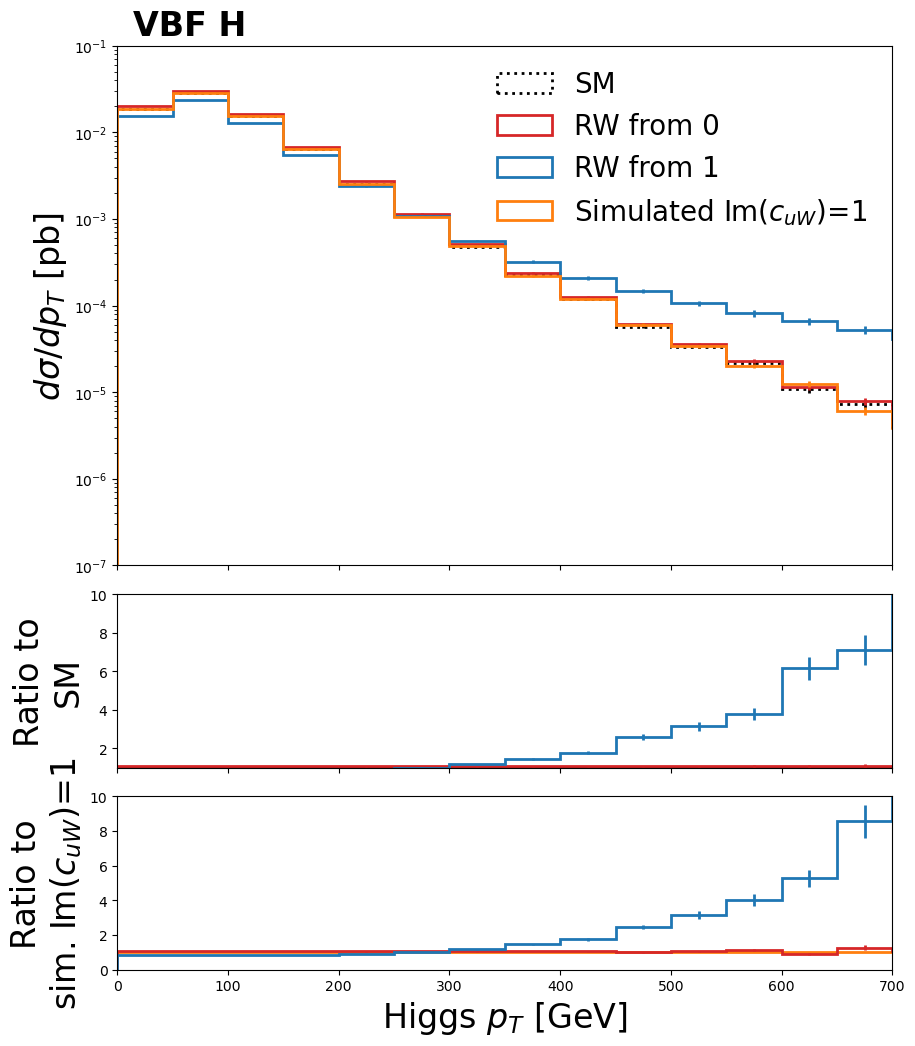

In [29]:
name=r'$d\sigma / dp_{T}$ [pb]'

samp3 = "VBF_SMEFTsim_topU3l_Direct_cuWIm"
output3 = util.load("coffea/"+samp3+".coffea")
d = output3['hpt']

plot_with_ratio('cuWIm', 1, name, h1, h2, d, rebin=10)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[9.98724674e+05 1.49956168e+06 8.19379829e+05 3.40272066e+05
 1.35398744e+05 5.73920494e+04 2.54558374e+04 1.18793462e+04
 6.25491811e+03 3.03046927e+03 1.78865818e+03 1.13922988e+03
 5.71495655e+02 3.91433648e+02 2.11252984e+02 1.75999716e+02
 1.25157032e+02 6.64924274e+01 5.09126068e+01 1.56328221e+01]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[7.80746993e+05 1.16955142e+06 6.46639038e+05 2.73107316e+05
 1.18778762e+05 5.41384789e+04 2.81990970e+04 1.61241277e+04
 1.04397734e+04 7.40471530e+03 5.30230377e+03 4.05461732e+03
 3.32289286e+03 2.62085776e+03 2.07983286e+03 1.87459236e+03
 1.34024408e+03 1.10649456e+03 9.90001538e+02 7.23480760e+02]


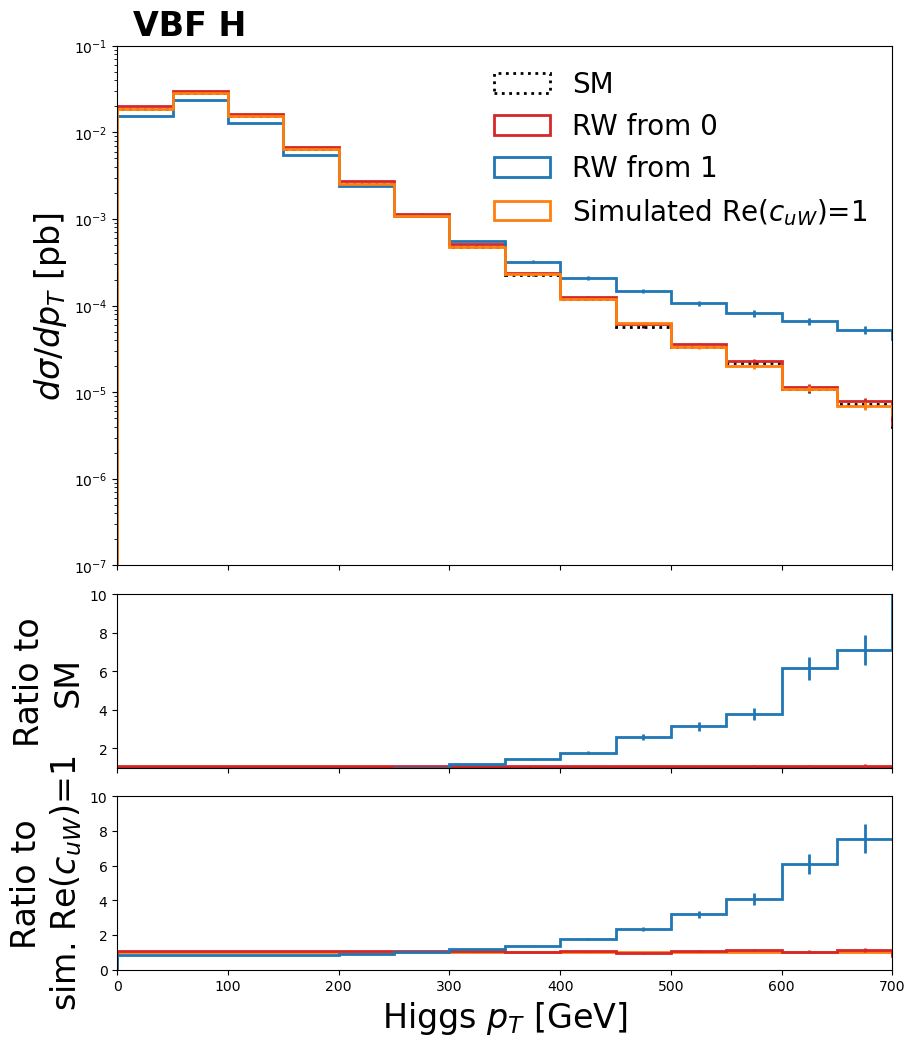

In [30]:
name=r'$d\sigma / dp_{T}$ [pb]'

samp3 = "VBF_SMEFTsim_topU3l_Direct_cuWRe"
output3 = util.load("coffea/"+samp3+".coffea")
d = output3['hpt']

plot_with_ratio('cuWRe', 1, name, h1, h2, d, rebin=10)